# Comunidades de Markov en sistemas recomendadores

En este notebook se desarrolla el proceso completo de implementación de un modelo de comunidades de Markov y un sistema recomendador de películas basado en MovieLens.

In [1]:
import markov_clustering as mc
import networkx as nx
import random
from scipy import spatial
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import math

### Procesamiento de los datos

Se realiza la limpieza de datos para ambos conjuntos (entrenamiento y pruebas). En el de entrenamiento se ponen como 0 todos los valores NaN para evitar problemas con la función distancia.

In [47]:
movies = {}

with open("ml-100k/u.item", encoding = "ISO-8859-1") as f:
    for line in f:
        ls = line.split('|')
        id = int(ls[0])
        title = ls[1]
        title = title.replace("'", '')
        movies[id] = title

interacts = {}
ratings = []

with open("ml-100k/u1.base", encoding = "ISO-8859-1") as f:
    for line in f:
        ls = line.split()
        user_id = int(ls[0])
        movie_id = int(ls[1])
        rating = float(ls[2])
        ratings.append((user_id, movie_id, rating))
        rating = (rating - 3)
        if rating != 0:
            rating /= abs(rating)
        if user_id in interacts:
            interacts[user_id][movie_id] = rating
        else:
            interacts[user_id] = {movie_id: rating}

adj = pd.DataFrame([[interacts[id][mv] if (id in interacts and mv in interacts[id]) else 0 for mv in movies.keys()] for id in interacts.keys()], index=interacts.keys(), columns=movies.keys())
rat = pd.DataFrame(ratings, columns=["user_id", "movie_id", "rating"])

adj = adj.sort_index()

adj.to_csv("data/train_graph.csv")
rat.to_csv("data/train_ratings.csv")

In [48]:
test_interacts = {}
ratings = []
with open("ml-100k/u1.test") as f:
    for line in f:
        ls = line.split()
        user_id = int(ls[0])
        movie_id = int(ls[1])
        rating = float(ls[2])
        ratings.append((user_id, movie_id, rating))
        rating = (rating - 3)
        if rating != 0:
            rating /= abs(rating)
        if user_id in test_interacts:
            test_interacts[user_id][movie_id] = rating
        else:
            test_interacts[user_id] = {movie_id: rating} 
            
adj = pd.DataFrame([[test_interacts[id][mv] if (id in test_interacts and mv in test_interacts[id]) else np.nan for mv in movies.keys()] for id in test_interacts.keys()], index=test_interacts.keys(), columns=movies.keys())
rat = pd.DataFrame(ratings, columns=["user_id", "movie_id", "rating"])

adj = adj.sort_index()

adj.to_csv("data/test_graph.csv")
rat.to_csv("data/test_ratings.csv")

In [49]:
print(adj)

     1     2     3     4     5     6     7     8     9     10    ...  1673  \
1     NaN   NaN   NaN   NaN   NaN   1.0   NaN   NaN   NaN   0.0  ...   NaN   
2     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
3     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
4     NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
5     1.0   0.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
457   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
458   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
459   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   
460   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   0.0  ...   NaN   
462   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   

     1674  1675  1676  1677  1678  1679  1680  1681  1682  
1  

### Estadísticas

Ahora que el dataset está listo para ser usado, vamos a hallar algunas estadísticas que pueden resultar útiles para elegir y analizar posteriormente los algoritmos de recomendación.

In [5]:
gr = pd.read_csv("data/train_graph.csv", index_col=0)
adj = gr.to_numpy()

print("---Grafo de Valoraciones---")
print("Peliculas:", gr.shape[1])
print("Usuarios:", gr.shape[0])

interacciones = np.count_nonzero(adj)
print("Valoraciones no nulas:", interacciones)
print()
media = float(interacciones) / gr.shape[0]
print("Media de valoraciones por usuario:", media)
print("Desv. tipica valoraciones por usuario:", statistics.stdev(np.count_nonzero(adj, axis=1)))
print()

print("Media de valoraciones por pelicula:", float(interacciones) / gr.shape[1])
print("Desv. tipica valoraciones por película:", statistics.stdev(np.count_nonzero(adj, axis=0)))
print()

print("Densidad del grafo:", float(interacciones) / (gr.shape[0]*gr.shape[1]) * 100, "%")

---Grafo de Valoraciones---
Peliculas: 1682
Usuarios: 943
Valoraciones no nulas: 58037

Media de valoraciones por usuario: 61.54506892895016
Desv. tipica valoraciones por usuario: 59.81638571495272

Media de valoraciones por pelicula: 34.50475624256837
Desv. tipica valoraciones por película: 50.08991914547278

Densidad del grafo: 3.6590409589149915 %


### Comparativa de las distancias

Este fragmento de código permite calcular de forma rápida la densidad del grafo resultatnte para distintas distancias y umbrales. Esto se ha usado como herramienta para elegir distancia y umbral.

In [6]:
def densidad(grafo, distancia, lim, peliculas=None):
    if peliculas:
        grafo_recortado = grafo[peliculas]
    else:
        grafo_recortado = grafo
    adj = grafo_recortado.to_numpy()
    dist = spatial.distance.pdist(adj, distancia)
    edges = dist <= lim
    return np.count_nonzero(edges) / float(len(edges))

In [7]:
print(densidad(gr, 'jaccard', .9))

0.08128955562610182


### Creación del grafo de usuarios

In [8]:
lim = 0.87
l = len(gr.index)
user_graph = nx.Graph()
user_graph.add_nodes_from(gr.index)
distancias = np.empty((l, l))

for i in range(l):
    a = gr.iloc[i]
    a_row = a.to_numpy()
    a_name = a.name
    for j in range(i + 1, l):
        b = gr.iloc[j]
        b_row = b.to_numpy()
        b_name = b.name
        dist = spatial.distance.jaccard(a_row, b_row)
        distancias[i][j] = dist
        distancias[j][i] = dist
        if dist <= lim:
            user_graph.add_edge(a_name, b_name)

In [9]:
print("Densidad: ", nx.density(user_graph))
edges = []
for node in user_graph.nodes:
    count = 0
    for edge in user_graph.edges:
        if node in edge:
            count +=1
    edges.append(count)
print("Edges/node:", statistics.mean(edges))
print("stdev edges/node:", statistics.stdev(edges))

Densidad:  0.03255634882574248
Edges/node: 30.668080593849417
stdev edges/node: 39.32370301911747


### Clustering de Markov

In [10]:
user_matrix = nx.to_scipy_sparse_matrix(user_graph)
result = mc.run_mcl(user_matrix, inflation=2.2)
clusters = mc.get_clusters(result)

C:\Users\leand\AppData\Local\Temp\ipykernel_16132\640623641.py:1: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  user_matrix = nx.to_scipy_sparse_matrix(user_graph)


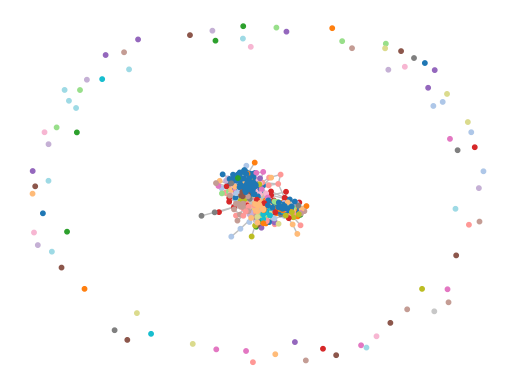

In [11]:
mc.draw_graph(user_matrix, clusters, node_size=10, with_labels=False, edge_color="silver")

In [12]:
ncom = len(clusters)
print(user_graph)

Graph with 943 nodes and 14460 edges


### Relaciones entre comunidades

A continuación se formará un grafo con las comunidades con uno de los métodos empleados para ver cómo se relacionan y abordar el problema de los nodos aislados. Este grafo se empleará para realizar la recomendación.

In [13]:
def find_com(node, comunidades):
    for cl in comunidades:
        if node - 1 in cl:
            return comunidades.index(cl)
    return None

In [14]:
com_graph = nx.Graph()
enlaces = np.zeros((ncom,ncom), dtype=np.int)
com_graph.add_nodes_from([i for i in range(ncom)])
for a,b in user_graph.edges:
    com_a = find_com(a, clusters)
    com_b = find_com(b, clusters)
    if com_a != com_b:
        enlaces[com_a, com_b] += 1
        enlaces[com_b, com_a] += 1
for i in range(ncom):
    for j in range(i + 1, ncom):
        if enlaces[i][j] > 0.5:
            com_graph.add_edge(i, j, weight=enlaces[i][j])

C:\Users\leand\AppData\Local\Temp\ipykernel_16132\3280428003.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  enlaces = np.zeros((ncom,ncom), dtype=np.int)


### Gestión de nodos aislados

Una vez se analiza un los usuarios como miembros de comunidades, es necesario s¡resolver el problema de aislamiento para poder recomendar películas a todo el mundo.

In [36]:
com_graph_2 = com_graph.copy()

In [37]:
aislados = [i for i in range(ncom) if len(com_graph_2.edges([i])) == 0]
print("Comunidades aisladas:",len(aislados))

Comunidades aisladas: 81


Forzando conexiones entre todas las comunidades es posible hacer recomendaciones a todo el mundo, aunque este aislado como usuario, a través de caminos entre comunidades. Se va a buscar (al menos) un enlace para cada comunidad aislada y se van a añadir al grafo.

In [38]:
def find_closest(user_idx, distances):
    vector = distances[user_idx]
    top = np.min(vector[np.nonzero(vector)])
    return list(vector).index(top)

In [39]:
for i in aislados:
    rel_coms = {}
    for j in clusters[i]:
        n = find_closest(j, distancias) + 1
        rel_com = find_com(n, clusters)
        if rel_com in rel_coms:
            rel_coms[rel_com] += 1
        else:
            rel_coms[rel_com] = 1
            
    top = max(rel_coms.values())
    flag = 0
    for j in rel_coms:
        if rel_coms[j] == top and flag < 5:
            flag += 1
            com_graph_2.add_edge(i, j, weight=1)

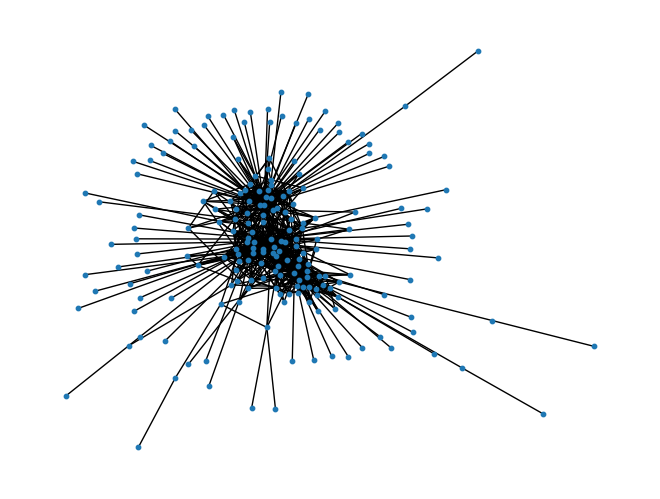

In [40]:
nx.draw(com_graph_2, node_size=10, labels={})

### Características del modelo

Se tomarán ciertas medidas del modelo resultante para entenderlo mejor.

In [41]:
print("Número de comunidades: ", len(clusters))
tam = [len(cluster) for cluster in clusters]
print("Usuarios por comunidad: ", statistics.mean(tam))
print("Deviación tamaño comunidades: ", statistics.stdev(tam))
print("Densidad grafo comunidades: ", nx.density(com_graph_2))
print("Diámetro grafo comunidades: ", nx.diameter(com_graph_2))
excent = [nx.eccentricity(com_graph_2, v=node) for node in com_graph_2.nodes]
print("Excentricidad media: ", statistics.mean(excent))
vecinos = [len(com_graph_2.edges(node)) for node in com_graph_2.nodes]
print("Media de vecinos: ", statistics.mean(vecinos))
print("Desviación de vecinos: ", statistics.stdev(vecinos))

Número de comunidades:  200
Usuarios por comunidad:  4.715
Deviación tamaño comunidades:  24.182176562844443
Densidad grafo comunidades:  0.03708542713567839
Diámetro grafo comunidades:  7
Excentricidad media:  5.205
Media de vecinos:  7.38
Desviación de vecinos:  10.478770114645034


In [42]:
print("Usuarios inicialmente aislados: ", len([user for user in user_graph.nodes if len(user_graph.edges(user)) == 0]))
print("Cantidad comunidades aisladas: ", len(aislados))
tam = [len(clusters[i]) for i in aislados]
print("Número de usuarios medio aislados: ", statistics.mean(tam))
tam = [len(clusters[i]) for i in range(len(aislados)) if i not in aislados]
print("Número de usuarios medio no aislados: ", statistics.mean(tam))
print("Deviación tamaño comunidades no aisladas: ", statistics.stdev(tam))
print(tam)

Usuarios inicialmente aislados:  81
Cantidad comunidades aisladas:  81
Número de usuarios medio aislados:  1
Número de usuarios medio no aislados:  12.275862068965518
Deviación tamaño comunidades no aisladas:  44.20676819794631
[317, 7, 2, 99, 7, 5, 2, 4, 2, 2, 3, 3, 2, 2, 6, 11, 3, 2, 6, 3, 1, 2, 2, 6, 94, 4, 10, 2, 4, 2, 6, 1, 3, 2, 2, 3, 9, 4, 1, 2, 5, 5, 2, 3, 4, 5, 5, 3, 2, 5, 2, 5, 3, 5, 2, 4, 1, 3]


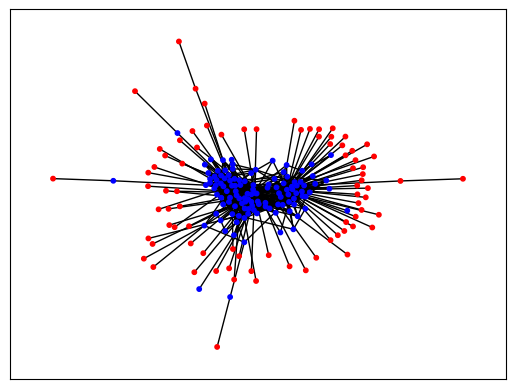

In [43]:
nx.draw_networkx(com_graph_2, node_size=10, labels={}, nodelist=com_graph_2.nodes, node_color=["red" if node in aislados else "blue" for node in com_graph_2.nodes])

In [44]:
diff = [len(com_graph_2.edges(node)) - len(com_graph.edges(node)) for node in com_graph.nodes]
print("Máxima diferencia: ", max(diff))
node = diff.index(max(diff))
print("Nodo de acumulación: ", node)
print("Tamaño del nodo: ", len(clusters[node]))

Máxima diferencia:  26
Nodo de acumulación:  0
Tamaño del nodo:  317


### Recomendación

A continuación se implementa un el algoritmo de recomendación.

In [66]:
def recommend(user, comunidades, modelo):
    user_com = find_com(user, comunidades)
    relevant_users = [i+1 for i in comunidades[user_com] if i + 1 != user]
    for _, neighbor in modelo.edges(user_com):
        relevant_users.extend([i+1 for i in comunidades[neighbor]])
    relevant_users.sort()
    
    rel_matrix = gr.loc[relevant_users]
    cols = [i for i in gr.columns if int(i) not in interacts[user]]
    rel_matrix = rel_matrix[cols]
    scores = rel_matrix.sum().sort_values(ascending=False)
    return scores[scores != 0]

In [67]:
score = recommend(436, clusters, com_graph_2)
print(score)

174    213.0
181    161.0
173    158.0
79     152.0
64     146.0
       ...  
831    -17.0
260    -18.0
29     -18.0
231    -24.0
122    -27.0
Length: 1296, dtype: float64


El usuario 436 no alcanza las 10 películas positivas, lo que podría resultar problemático en futuros algoritmos.

### Evaluación

Es necesario valorar cuánto acieran estas listas y cómo se posicionan dichos aciertos.
Como es evidente que no se pueden recomendar tantas películas (muy baja precisión) veamos como desciende el recall y aumenta la precisión al reducir las recomendaciones.

In [68]:
usuarios_aislados = []
for com in aislados:
    usuarios_aislados.extend(clusters[com])
print(usuarios_aislados)

[4, 13, 18, 19, 20, 26, 30, 37, 48, 66, 74, 75, 77, 79, 97, 101, 105, 109, 115, 116, 121, 155, 160, 166, 168, 171, 173, 179, 180, 182, 185, 194, 195, 201, 202, 207, 210, 211, 218, 222, 223, 224, 225, 227, 234, 242, 245, 254, 261, 263, 269, 278, 279, 288, 299, 309, 324, 330, 335, 339, 357, 381, 398, 435, 470, 570, 603, 608, 616, 671, 725, 759, 777, 821, 827, 842, 848, 899, 913, 927, 929]


Se evaluará el resultado para distintos tamaños de conjunto recomendado.

In [75]:
list_tp, list_tpa, list_fp, list_fpa, list_tn, list_tna, list_fn, list_fna = [], [], [], [], [], [], [], []

for k in range(1,16):
    tp, tpa = 0, 0
    fp, fpa = 0, 0
    tn, tna = 0, 0
    fn, fna = 0, 0

    for user in test.index:
        score = recommend(user, clusters, com_graph_2)
        score = score[score > 0]
        if len(score) > k:
            score = score[:k]
            
        flag = (user - 1 in usuarios_aislados)
        for item in test.columns:
            rating = test.loc[user][item]
            if pd.notna(rating):
                if item in score:
                    if rating == 1:
                        tp += 1
                        if flag:
                            tpa += 1
                    else:
                        fp += 1
                        if flag:
                            fpa += 1
                else:
                    if rating == 1:
                        fn += 1
                        if flag:
                            fna += 1
                    else:
                        tn += 1
                        if flag:
                            tna += 1
                            
    list_tp.append(tp)
    list_tpa.append(tpa)
    list_fp.append(fp)
    list_fpa.append(fpa)
    list_tn.append(tn)
    list_tna.append(tna)
    list_fn.append(fn)
    list_fna.append(fna)

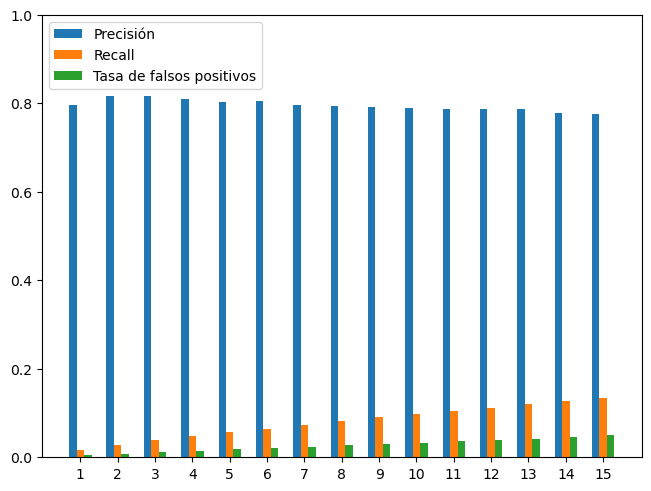

In [76]:
k = [i for i in range(1,16)]
measures = {
    'Precisión': [list_tp[i]/float(list_tp[i] + list_fp[i]) for i in range(15)],
    'Recall': [list_tp[i]/float(list_tp[i] + list_fn[i]) for i in range(15)],
    'Tasa de falsos positivos': [list_fp[i]/float(list_fp[i] + list_tn[i]) for i in range(15)],
}

x = np.arange(len(k))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in measures.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim(0, 1)
ax.legend(loc='upper left')
ax.set_xticks(x + width, k)
plt.show()

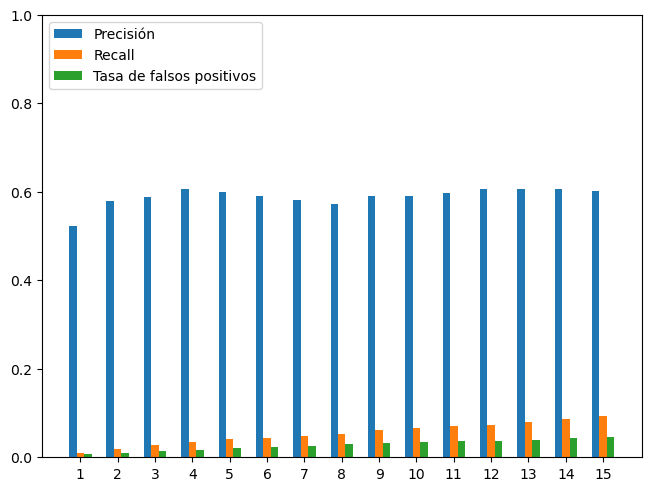

In [77]:
k = [i for i in range(1,16)]
measures = {
    'Precisión': [list_tpa[i]/float(list_tpa[i] + list_fpa[i]) for i in range(15)],
    'Recall': [list_tpa[i]/float(list_tpa[i] + list_fna[i]) for i in range(15)],
    'Tasa de falsos positivos': [list_fpa[i]/float(list_fpa[i] + list_tna[i]) for i in range(15)],
}

x = np.arange(len(k))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in measures.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim(0, 1)
ax.legend(loc='upper left')
ax.set_xticks(x + width, k)
plt.show()

Analizando detalladamente el caso k = 4.

In [78]:
test = pd.read_csv("data/test_graph.csv", index_col=0)

tp, tpa = 0, 0
fp, fpa = 0, 0
tn, tna = 0, 0
fn, fna = 0, 0

for user in test.index:
    score = recommend(user, clusters, com_graph_2)
    score = score[score > 0]
    if len(score) > 4:
        score = score[:4]
    flag = (user - 1 in usuarios_aislados)
    for item in test.columns:
        rating = test.loc[user][item]
        if pd.notna(rating):
            if item in score:
                if rating == 1:
                    tp += 1
                    if flag:
                        tpa += 1
                else:
                    fp += 1
                    if flag:
                        fpa += 1
            else:
                if rating == 1:
                    fn += 1
                    if flag:
                        fna += 1
                else:
                    tn += 1
                    if flag:
                        tna += 1

In [79]:
precision = tp / float(tp + fp)
recall = tp / float(tp + fn)
fpr = fp / float(fp + tn)
print('Precision:' + str(precision))
print("Recall: " + str(recall))
print("False Positive Rate: " + str(fpr))
print("------")
precision = tpa / float(tpa + fpa)
recall = tpa / float(tpa + fna)
fpr = fpa / float(fpa + tna)
print('Precision aislados:' + str(precision))
print("Recall aislados: " + str(recall))
print("False Positive Rate aislados: " + str(fpr))
print("------")
tpn = tp - tpa
fpn = fp - fpa
tnn = tn - tna
fnn = fn - fna
precision = tpn / float(tpn + fpn)
recall = tpn / float(tpn + fnn)
fpr = fpn / float(fpn + tnn)
print('Precision no aislados:' + str(precision))
print("Recall no aislados: " + str(recall))
print("False Positive Rate no aislados: " + str(fpr))

Precision:0.8099547511312217
Recall: 0.047797062750333776
False Positive Rate: 0.014375356531660012
------
Precision aislados:0.6060606060606061
Recall aislados: 0.0336417157275021
False Positive Rate aislados: 0.016720257234726688
------
Precision no aislados:0.8324958123953099
Recall no aislados: 0.04947242683655186
False Positive Rate no aislados: 0.013869625520110958


### Interfaz

In [80]:
import ipywidgets as ipw
from IPython.display import display

In [82]:
max_rec = ipw.IntSlider(value=5, min=1, max=15, step=1, description='max_rec: ')
user = ipw.Dropdown(options=gr.index, description='User ID: ')
display(max_rec, user)

IntSlider(value=5, description='max_rec: ', max=15, min=1)

Dropdown(description='User ID: ', options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, …

In [86]:
score = recommend(user.value, clusters, com_graph_2)
score = score[score > 0]
if len(score) > max_rec.value:
    score = score[:max_rec.value]
print('Películas recomendadas para el usuario ' + str(user.value) + ': ' + str([movies[int(i)] for i in score.index]))

Películas recomendadas para el usuario 436: ['Raiders of the Lost Ark (1981)', 'Return of the Jedi (1983)', 'Princess Bride, The (1987)', 'Fugitive, The (1993)']
